#  Geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

# 1 - Formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

---
**Unknown variables** are:
- $\underline{x}$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta t_p (\underline{x},\underline{x}_t^i)$ : difference between actual $(t_r^i - t_e^i)$ and an priori time $t_p(\underline{x},\underline{x}_t^i)$ of propagation between $\underline{x}$ and $\underline{x}_t^i$.

For simplicity, we assume the assumed propagation time is a function of range only: $t_p(\underline{x},\underline{x}_t^i) = t_p(|| \underline{x} - \underline{x}_t^i ||)$.

$t_p$ may for example be given by an a priori estimate of velocity ($c_b$) along with a measure of velocity uncertainty ($e_c$). In this case, we expect the error on time to grow with range according to: $e_{tp} \propto || \underline{x}_b - \underline{x}_t^i || /e_c$, where $\underline{x}_b$ is an a priori estimate for the float location.

A priori standard deviations for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p  (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta x}$, $e_{tp}$.

Background (a priori) estimates for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


---
The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t) &= 
||\underline{x} - \underline{x}_b||^2 /e_x^2 
+ \sum_i \epsilon_i \times  \delta t (\underline{x},\underline{x}_t^i)^2 / e_{tp}^2 \\
&= 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \sum_i \epsilon_i \times \big [ \tilde{t}_r^i - \delta t  - t_e^i  -  t_p(\underline{x},\underline{x}_t^i) \big ]^2 / e_{tp}^2
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from clib.geolocation_1D import *

---
---
# 2 - Creation of an ensemble of sources

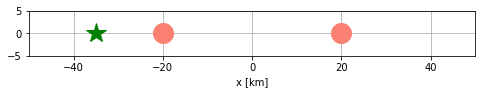

In [2]:
### create an ensemble of sources
dx=40. *1.e3 # in meters
sources=[]
sources.append(source( dx*.5, 0))
sources.append(source(-dx*.5, 0))



Ns = len(sources)

### init a receiver
#r=receiver(0. *1.e3, 0. *1.e3, e_x=10.e3)
r=receiver(-35. *1.e3, 0, e_x=10.e3, e_dt=0.)

### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=None, e_min=1.e-3)  #e_min on time (Cramer-Rao)

### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
plt.ylim([-5, 5])
plt.xlim([-50,50])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

**- A priori uncertainties and estimates are :**

In [3]:
# a priori uncertainties : 
print("e_dx  = %.1f m     (uncertainty on transducer position)" %sources[0].e_dx)
print("e_x   = %.1f m  (uncertainty on underwater float position)" %r.e_x)

e_dx  = 10.0 m     (uncertainty on transducer position)
e_x   = 10000.0 m  (uncertainty on underwater float position)


**- The true clock offset is :**

In [4]:
print('dt = %.2e s' %(r.dt))

dt = 0.00e+00 s


**- Unchanged variables during simulations are : **

In [5]:
print("s.x_t :", [s.x_t for s in sources])   #due to uncertainty on transducer position 
print("s.dx  :", [s.dx for s in sources])

s.x_t : [array([20000.02242718]), array([-20007.29698981])]
s.dx  : [array([0.02242718]), array([-7.29698981])]


---
---
# 3 - Calculation and plot functions for transects

**- Function "simu" : simulations for one receiver position. Returns rms and bias.  **

In [6]:
def simu (r, sources, Nmc, var, t_drift) : 
    ''' It returns rms and bias on x position for one receiver position'''
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=t_drift)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, \
                                                                         clock_drift=t_drift, \
                                                                         x0=[x[i], dt[i]])
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2 ) )
    # biais on the receiver position
    bias_x = x[np.where(su==1)].mean()-r.x
    bias_y = y[np.where(su==1)].mean()-r.y
    #print('x[np.where(su==1)].mean() :' , x[np.where(su==1)].mean())
    #print('r.x : ', r.x)
    return (d_rms, bias_x, su)




**- Calculation and plot functions for transects : **

In [50]:
from ipywidgets import FloatProgress
from IPython.display import display


def transect (sources, X, Y, Nmc, var, clock_drift = False, e_dt=0.01) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    
    r = receiver(X[0], Y, e_dt=e_dt)
    r_dt = r.dt
    
    f = FloatProgress(value = 0., min=0., max=100., step=1., orientation='horizontal', description = 'Loading :')
    display(f)
    
    for i in range (len(X)) :
        
        f.value = i/len(X)*100.

        # init a receiver
        r = receiver(X[i], Y, e_dt=e_dt)
        #r.dt = r_dt # unchanged variable during simulations 
        #
        d_rms, bias_x, su = simu (r, sources, Nmc, var = var, t_drift = clock_drift)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        Success_t[:,i] = su

    f.value = 100.
    
    return RMS_t, BiasX_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('mean (rms) = %.1fm  /// max (rms) = %.1f m' % (np.mean(RMS_t), np.max(RMS_t)))
    print('mean (bias) = %.1fm /// max (bias) = %.1f m' % (np.mean(Biais_t), np.max(Biais_t)))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error' )
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias on x ' )
    
    plt.show()
    

---
---
# 4 - Transects 

**- Creation of a transect : **

In [57]:
L = 100.* 1.e3
X = np.linspace(-L/2.,L/2.,100)  # resolution : 1km
Y = 0. 

---
### A - Avec une erreur sur le temps d'arrivée de 1 ms 

In [9]:
print("e_tp   = %.3f s    (uncertainty on arrival time)" %pmap.e_tp(0.))

e_tp   = 0.001 s    (uncertainty on arrival time)


In [10]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources, X, Y, Nmc, var, clock_drift = False ) 

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 1.1m  /// max (rms) = 1.2 m
mean (bias) = 0.0m /// max (bias) = 0.2 m


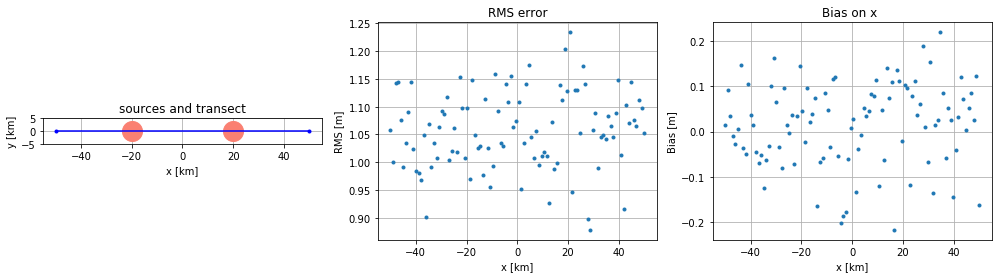

In [11]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

---
---
---

Maintenant, on augmente l'erreur sur le temps d'arrivée (dû à une détection du mauvais rayon ou autre...). 

(D'après les calculs de célérité équivalente (en Méditerrannée), on a un ecart-type sur la distance de 70m environ. Cela correspond à un cart type sur les temps d'arrivée de 45ms.)

---
---
---

### B - Avec une erreur sur le temps d'arrivée de 10 ms 

In [12]:
### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-2, e_min=1.e-3)
print("e_tp   = %.3f s    (uncertainty on arrival time)" %pmap.e_tp(0.))

e_tp   = 0.010 s    (uncertainty on arrival time)


In [14]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources, X, Y, Nmc, var, clock_drift = False )

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 10.6m  /// max (rms) = 11.8 m
mean (bias) = 0.0m /// max (bias) = 2.7 m


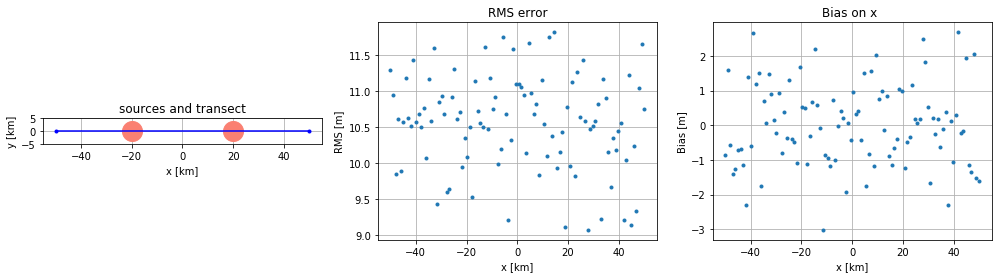

In [15]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

---
---
### C - Avec une erreur sur le temps d'arrivée de 100 ms 

In [16]:
### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-1, e_min=1.e-3)
print("e_tp   = %.3f s    (uncertainty on arrival time)" %pmap.e_tp(0.))

e_tp   = 0.100 s    (uncertainty on arrival time)


In [17]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources, X, Y, Nmc, var, clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 106.8m  /// max (rms) = 161.4 m
mean (bias) = 1.0m /// max (bias) = 26.7 m


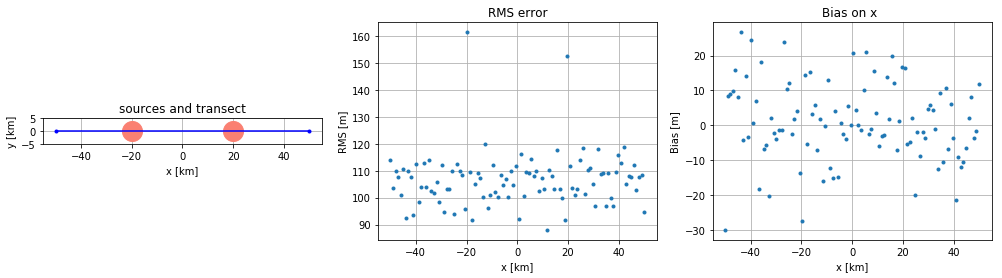

In [18]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

# Interprétation : Sans dérive d'horloge, et en ne faisant varier que l'erreur sur le temps d'arrivée, l'erreur finale sur la position ne dépend pas du range ni de la position des sources (RMS ~ e_dt*1500).  

---
---
### D - En ajoutant des sources

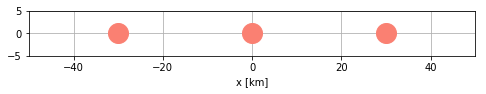

In [21]:
### create an ensemble of sources
dx=50. *1.e3 # in meters
sources3=[]
sources3.append(source( dx*0., 0))
sources3.append(source(-dx*.6, 0))
sources3.append(source( dx*.6, 0))
Ns = len(sources3)

### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources3]
plt.ylim([-5, 5])
plt.xlim([-dx/1000.,dx/1000.])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

In [22]:
### init mapping  (we keep the one of previous section)
#pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-1, e_min=1.e-3)  #e_min on time (Cramer-Rao)

In [23]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 86.2m  /// max (rms) = 113.0 m
mean (bias) = 0.4m /// max (bias) = 23.5 m


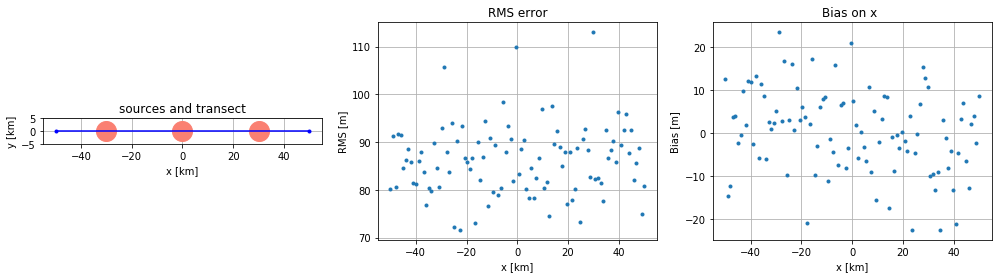

In [24]:
plot_transect(sources3, X, Y, RMS_t, BiasX_t)

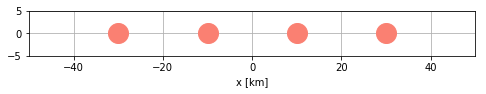

In [28]:
### create an ensemble of sources
dx=50. *1.e3 # in meters
sources4=[]
sources4.append(source(-dx*0.2, 0))
sources4.append(source( dx*0.2, 0))
sources4.append(source(-dx*.6, 0))
sources4.append(source( dx*.6, 0))
Ns = len(sources4)

### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources4]
plt.ylim([-5, 5])
plt.xlim([-dx/1000.,dx/1000.])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

In [58]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources4, X, Y, Nmc, var, clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 74.8m  /// max (rms) = 89.0 m
mean (bias) = -2.1m /// max (bias) = 13.9 m


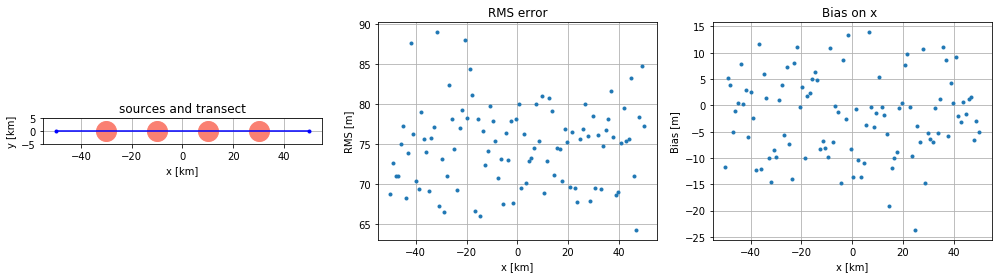

In [59]:
plot_transect(sources4, X, Y, RMS_t, BiasX_t)

### Lien entre RMS et nombre de sources

In [60]:
##              mean(RMS)   max(RMS)    
### 2 sources :  106.8m     161.4m
### 3 sources :  86.2m      113.0m
### 4 sources :  74.4m      100.5m 
### 5 sources :  66.8m      82.2m

## RMS avec 6 sources  : RMS(2sources)/sqrt(3)   (2*3=6sources)
## RMS avec 8 sources  : RMS(2sources)/sqrt(4)   (2*4=8sources)

In [61]:
xx = np.array([2., 3., 4., 5.])
XX = 1/np.sqrt(xx)
YY = np.array([106.8, 86.2, 74.4, 66.8])

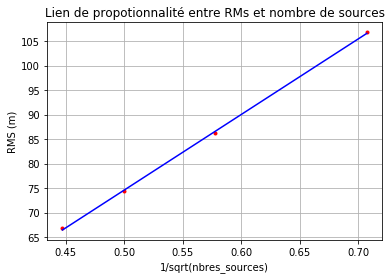

In [62]:
plt.plot(XX,YY,'r.')
res = np.polyfit(XX,YY,1)
plt.plot(XX,res[0]*XX+res[1],'b')
plt.xlabel('1/sqrt(nbres_sources)')
plt.ylabel('RMS (m)')
plt.title ('Lien de propotionnalité entre RMs et nombre de sources')
plt.grid()

# Interprétation : Sans dérive d'horloge, la RMS décroît proportionnellement à la racine carrée du nombre de sources. 

---
---
### E - Avec une dérive d'horloge : e_dt = 0.5s

- Dérive de l'horloge : 0.7 ppm
- Sur 10 jours : 10. * 86400. * 0.7e-6 = 0.6s

In [ ]:
### mean(RMS) suivant le nombre de sources (seulement dans la zone entre les sources)   
## 3 sources : 92.8 m 
## 4 sources : 77.2 m
## 5 sources : 70.2 m
#### On a bien toujours une décroissance en sqrt(Ns)

In [87]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = True, e_dt=0.5)

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations


mean (rms) = 284.3m  /// max (rms) = 1934.0 m
mean (bias) = -25.7m /// max (bias) = 1931.8 m


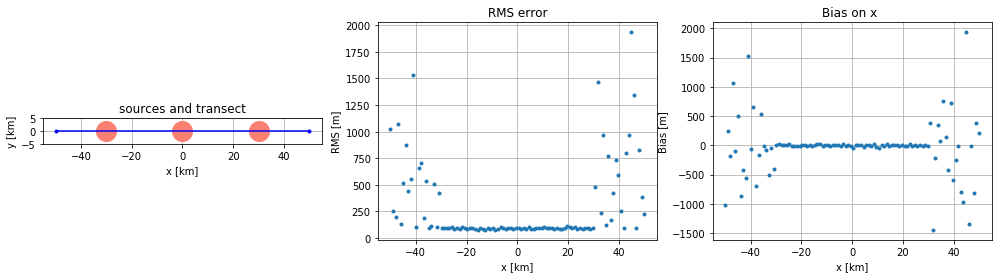

In [88]:
plot_transect(sources3, X, Y, RMS_t, BiasX_t)

In [89]:
np.mean(RMS_t[15:85])

143.28244934715815

---
### F - Avec une dérive d'horloge : e_dt = 0.1s

In [ ]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = True, e_dt=0.1)

mean (rms) = 121.5m  /// max (rms) = 340.2 m
mean (bias) = 4.0m /// max (bias) = 271.9 m


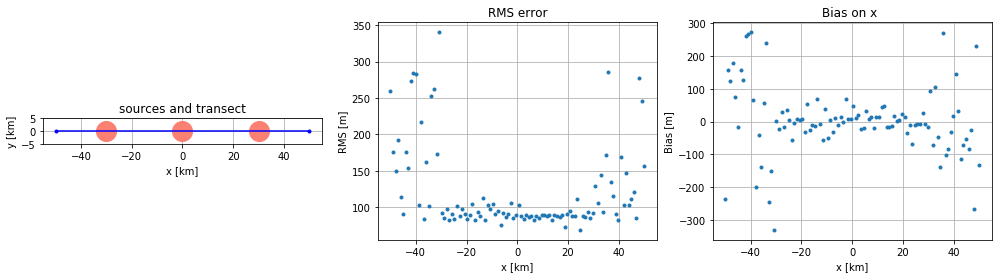

In [82]:
plot_transect(sources3, X, Y, RMS_t, BiasX_t)

In [83]:
np.mean(RMS_t[15:85])

102.79566685738067

---
### G - Avec une dérive d'horloge : e_dt = 0.05s

In [ ]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = True, e_dt=0.05)

mean (rms) = 98.6m  /// max (rms) = 191.6 m
mean (bias) = -0.5m /// max (bias) = 176.6 m


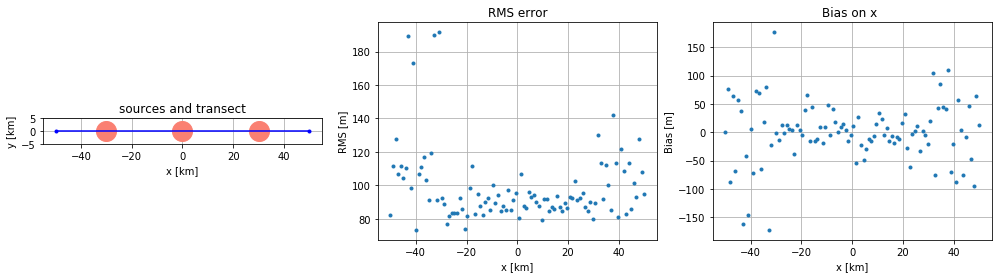

In [94]:
plot_transect(sources3, X, Y, RMS_t, BiasX_t)

In [95]:
np.mean(RMS_t[15:85])

93.90763081781971

---
### H - Avec une dérive d'horloge : e_dt = 0.01s

In [ ]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = True, e_dt=0.01)

mean (rms) = 88.3m  /// max (rms) = 139.3 m
mean (bias) = -0.5m /// max (bias) = 25.2 m


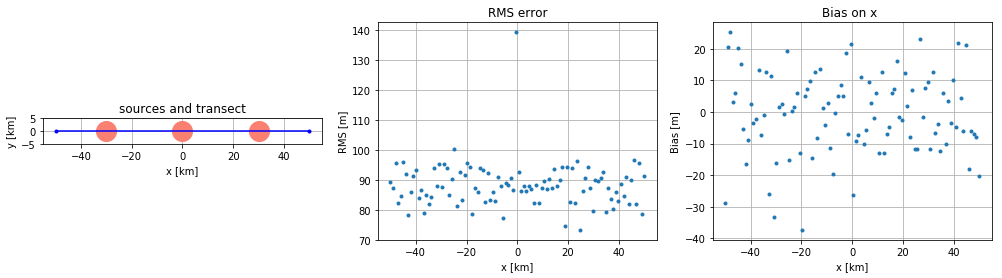

In [85]:
plot_transect(sources3, X, Y, RMS_t, BiasX_t)

In [86]:
np.mean(RMS_t[15:85])

88.83542384304579

---
### I - e_dt = 0.01s mais avec une erreur sur le temps d'arrivée e_tp = 1ms (au lieu de 0.1s précédemment)

In [96]:
### init mapping  (we keep the one of previous section)
pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-3, e_min=1.e-3)  #e_min on time (Cramer-Rao)

In [ ]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources3, X, Y, Nmc, var, clock_drift = True, e_dt=0.01)

mean (rms) = 5.3m  /// max (rms) = 35.1 m
mean (bias) = 0.7m /// max (bias) = 35.1 m


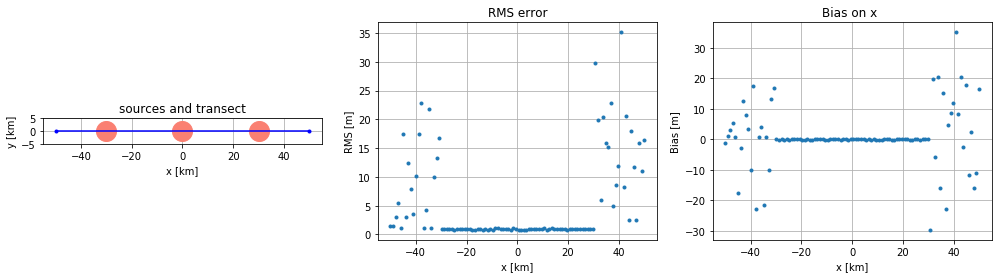

In [98]:
plot_transect(sources3, X, Y, RMS_t, BiasX_t)

---
# Interprétation : Plus la dérive est importante, plus les RMS sont élevées. Lorsque l'erreur e_dt (dérive) est plus importante que l'erreur e_tp (temps d'arrivée), les RMS explosent pour les flotteurs situés à l'extérieur des sources...

---
---
---
---
---
---
---
---
---
# ANNEXES

---
## A - One geolocalisation

In [12]:
r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
r.t_r_tilda

array([36.66724388,  9.9988081 ])

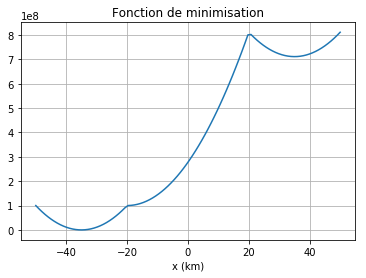

In [13]:
x, dt, success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False, plot_min=True)

In [14]:
print ("L'erreur sur la geolocalisation est de %.2f m." %(abs(r.x - x)))

L'erreur sur la geolocalisation est de 0.47 m.


---
---
## B - Statistical simulations for one receiver position

In [15]:
### minimization with adjusted a priori estimates
Nmc = 1000
x=np.zeros(Nmc)
dt=np.zeros(Nmc)

for i in range(Nmc):
    # solve a first time
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)
    # rerun with adjusted expected errors on propagation time
    for j in range(1):
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False, \
                                                                     x0=[x[i], dt[i]])

d_rms = np.sqrt( np.mean( (x - r.x)**2 ) )
bias_x = x.mean()-r.x
print('rms error : %.1f m \nx bias    : %.3f m ' %(d_rms, bias_x))

rms error : 1.0 m 
x bias    : -0.034 m 


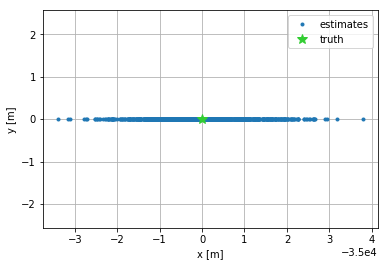

In [16]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,np.zeros(Nmc),'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()